In [1]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Argumentation Evaluation

This notebook evaluates the quality of different argumentative agents.

## Utilities

This section contains main configuration of the notebook as well as several utility functions. Make sure to change the paths to point to locations of your trained models.

In [2]:
import lime
import tqdm
import torch
import itertools
import numpy as np
import pandas as pd
import random as rnd
import seaborn as sns
import matplotlib.pyplot as plt
import lime.lime_tabular
from tianshou.data import Batch
import torch.nn.functional as F

In [3]:
from tqdm import trange 
from pathlib import Path
from shap import DeepExplainer
from typing import Optional, List, Literal, Union
from torch.utils.data import Subset
from tianshou.env import DummyVectorEnv
from tianshou.data import Batch, Collector, ReplayBuffer
from torch.utils.data import DataLoader

In [4]:
from argo.datasets.sepsis import get_debate_dataset, get_xai_debate_dataset, get_judge_dataset, SEPSIS_FEATURES_DEMOGRAPHIC, SEPSIS_FEATURES_OBSERVATIONAL
from argo.models.argumentator import MaskedPPO, make_argumentator
from argo.models.protagonist import DQNPolicy
from argo.models.clinician import ClinicianPolicy
from argo.envs.sepsis import SepsisArgumentationEnv
from argo.library.evaluation import run_debate

In [5]:
DEVICE = "cuda"
ACTIONS = [i for i in range(25)]
ACTIONS = list(itertools.product(["iv:0", "iv:1-50", "iv:50-180", "iv:180-530", "iv:>530"],
                                 ["vc:0", "vc:0.001-0.08", "vc:0.08:0.22", "vc:0.22-0.45", "vc:>0.45"]))
NUM_ARGUMENTS = 6
STATE_DIM = 44
SEED = 5568
SEEDS = [202302, 667495, 114159, 965751, 448102]
ACTION_DIM = len(ACTIONS)
RESULTS_DIR = Path("./results/")
ARGUMENTS = SEPSIS_FEATURES_DEMOGRAPHIC + SEPSIS_FEATURES_OBSERVATIONAL

In [14]:
DATA_PREFERENCES_PATH = "./assets/data/sepsis/test_preferences.pt"
DATA_XAI_BACKGROUND_PATH = "./assets/data/sepsis/xai_bg_dataset.pt"

JUDGE_PATH = "./assets/models/judge/judge.pt"
JUDGE_PATH_4ARG = "./assets/models/judge/judge.4.pt"
JUDGE_PATH_3ARG = "./assets/models/judge/judge.3.pt" # judge used for training the precommit agent

ARGUMENTATOR_SINGLE_ADAPTIVE_PATH = "./assets/models/argumentator/{n_args}/argumentator.isolated.pt"
ARGUMENTATOR_SINGLE_4ARG_PRECOMMIT_PATH = "./assets/models/argumentator/4/argumentator.isolated.2.pt"
ARGUMENTATOR_SINGLE_PRECOMMIT_PATH = "./assets/models/argumentator/{n_args}/argumentator.isolated.3.pt"
ARGUMENTATOR_DEBATE_MINIMAX_PATH = "./assets/models/argumentator/{n_args}/argumentator.debate-minimax.pt"
ARGUMENTATOR_DEBATE_MINIMAX_REWDIFF_PATH = "./assets/models/argumentator/{n_args}/argumentator.debate-minimax.rewdiff.pt"
ARGUMENTATOR_DEBATE_SELFPLAY_REWDIFF_PATH = "./assets/models/argumentator/{n_args}/argumentator.debate-selfplay.rewdiff.pt"
ARGUMENTATOR_DEBATE_SELFPLAY_PATH = "./assets/models/argumentator/{n_args}/argumentator.debate-selfplay.pt"

CONFUSER_ARGUMENTATOR_ADAPTIVE_PATH = "./assets/models/argumentator/{n_args}/confuser.isolated.pt"
CONFUSER_ARGUMENTATOR_4ARG_PRECOMMIT_PATH = "./assets/models/argumentator/4/confuser.isolated.2.pt"
CONFUSER_ARGUMENTATOR_PRECOMMIT_PATH = "./assets/models/argumentator/6/confuser.isolated.3.pt"
CONFUSER_DEBATE_MINIMAX_PATH = "./assets/models/argumentator/{n_args}/confuser.debate-minimax.pt"
CONFUSER_DEBATE_MINIMAX_REWDIFF_PATH = "./assets/models/argumentator/6/confuser.debate-minimax.rewdiff.pt"
CONFUSER_DEBATE_SELFPLAY_PATH = "./assets/models/argumentator/{n_args}/confuser.debate-selfplay.pt"
CONFUSER_DEBATE_SELFPLAY_REWDIFF_PATH = "./assets/models/argumentator/6/confuser.debate-selfplay.rewdiff.pt"
CONFUSER_SHAP_PATH = "./assets/models/argumentator/{n_args}/confuser.shap.pt"
CONFUSER_LIME_PATH = "./assets/models/argumentator/{n_args}/confuser.lime.pt"

In [8]:
_ = sns.set_style("darkgrid")
_ = torch.random.manual_seed(SEED)
_ = np.random.seed(SEED)

In [9]:
def evaluate(env, policy, episodes: int = 100, random: bool = False):
    stats = {
        "args": {arg: 0 for arg in ARGUMENTS},
        "args_per_action": {act: {arg: 0 for arg in ARGUMENTS} for act in range(len(ACTIONS))},
        "actions_per_arg": {arg: {act: 0 for act in range(len(ACTIONS))} for arg in ARGUMENTS},
        "rewards": [],
        "mean_reward": 0.0, 
    }

    for _ in trange(episodes):
        terminated, truncated = False, False
        obs, _ = env.reset()
        rewards = []
        args = set()

        while not (terminated or truncated):
            if random:
                act = rnd.randint(0, len(ARGUMENTS) - 1)
                obs, reward, terminated, truncated, _ = env.step(act)
            else:
                obs = {**obs, "args": np.expand_dims(obs["args"], axis=0), "args_mask": np.expand_dims(obs["args_mask"], axis=0), "obs": np.expand_dims(obs["obs"], axis=0)}
                act = policy(Batch(obs=obs, info={})).act.item()
                obs, reward, terminated, truncated, _ = env.step(act)

            if act not in args:
                stats["args"][ARGUMENTS[act]] += 1
                stats["args_per_action"][env.act.item()][ARGUMENTS[act]] += 1
                stats["actions_per_arg"][ARGUMENTS[act]][env.act.item()] += 1
                args.add(act)

            if reward != 0.0:
                rewards.append(reward) # we only care about final reward

        if len(rewards):
            stats["rewards"].append(sum(rewards) / len(rewards))

    stats["mean_reward"] = sum(stats["rewards"]) / episodes # TODO: not universal, this works because rewards are sparse, non-zero only on episode's end
    return stats

In [10]:
def plot_argument_distribution(env, policy, episodes: int = 100, title: str = None, axes = None, random = False, sort = False):
    if axes is None:
        axes = plt.axes()

    stats = evaluate(env, policy, episodes=episodes, random=random)
    counts = list(stats["args"].values())
    
    data = [(count, label) for count, label in zip(counts, ARGUMENTS)]
    data = sorted(data, reverse=True) if sort else data
    data_count = list(map(lambda i: i[0], data))
    data_label = list(map(lambda i: i[1], data))

    plt.setp(axes.xaxis.get_majorticklabels(), rotation=90)
    axes.tick_params(color="#2D2727", labelcolor="#2D2727")
    axes.set_title(title, color="#2D2727", size=14)
    axes.bar(range(len(data_count)), data_count, tick_label=data_label, color="#98EECC", edgecolor="#5dc59c")

## Agent Comparison

This section runs some basic evaluation on the argumentative policies.

In [11]:
judge = torch.load(JUDGE_PATH, map_location=torch.device("cpu")).eval()
judge_3arg = torch.load(JUDGE_PATH_3ARG, map_location=torch.device("cpu")).eval()
judge_4arg = torch.load(JUDGE_PATH_4ARG, map_location=torch.device("cpu")).eval()
device = torch.device(DEVICE)
_, dataloader, _ = get_debate_dataset(load_path=DATA_PREFERENCES_PATH, device=torch.device("cpu"), num_workers=0, batch_size=1)

In [15]:
env = SepsisArgumentationEnv(dataloader=dataloader, judge=judge, action_dim=ACTION_DIM, state_dim=STATE_DIM, num_arguments=NUM_ARGUMENTS, eval=True)

model_argumentator_adaptive = torch.load(ARGUMENTATOR_SINGLE_ADAPTIVE_PATH.format(n_args=NUM_ARGUMENTS), map_location=device)["model"].eval()
model_argumentator_adaptive.ret_rms = torch.load(ARGUMENTATOR_SINGLE_ADAPTIVE_PATH.format(n_args=NUM_ARGUMENTS), map_location=device)["ret_rms"]
model_argumentator_adaptive._deterministic_eval = True

model_argumentator_4arg = torch.load(ARGUMENTATOR_SINGLE_4ARG_PRECOMMIT_PATH, map_location=device)["model"].eval()
model_argumentator_4arg.ret_rms = torch.load(ARGUMENTATOR_SINGLE_4ARG_PRECOMMIT_PATH, map_location=device)["ret_rms"]
model_argumentator_4arg._deterministic_eval = True

model_argumentator_precommit = torch.load(ARGUMENTATOR_SINGLE_PRECOMMIT_PATH.format(n_args=NUM_ARGUMENTS), map_location=device)["model"].eval()
model_argumentator_precommit.ret_rms = torch.load(ARGUMENTATOR_SINGLE_PRECOMMIT_PATH.format(n_args=NUM_ARGUMENTS), map_location=device)["ret_rms"]
model_argumentator_precommit._deterministic_eval = True

model_debate_minimax = torch.load(ARGUMENTATOR_DEBATE_MINIMAX_PATH.format(n_args=NUM_ARGUMENTS), map_location=device)["model"].eval()
model_debate_minimax.ret_rms = torch.load(ARGUMENTATOR_DEBATE_MINIMAX_PATH.format(n_args=NUM_ARGUMENTS), map_location=device)["ret_rms"]
model_debate_minimax._deterministic_eval = True

model_debate_minimax_4arg = torch.load(ARGUMENTATOR_DEBATE_MINIMAX_PATH.format(n_args=4), map_location=device)["model"].eval()
model_debate_minimax_4arg.ret_rms = torch.load(ARGUMENTATOR_DEBATE_MINIMAX_PATH.format(n_args=4), map_location=device)["ret_rms"]
model_debate_minimax_4arg._deterministic_eval = True

model_debate_minimax_rewdiff = torch.load(ARGUMENTATOR_DEBATE_MINIMAX_REWDIFF_PATH.format(n_args=NUM_ARGUMENTS), map_location=device)["model"].eval()
model_debate_minimax_rewdiff.ret_rms = torch.load(ARGUMENTATOR_DEBATE_MINIMAX_REWDIFF_PATH.format(n_args=NUM_ARGUMENTS), map_location=device)["ret_rms"]
model_debate_minimax_rewdiff._deterministic_eval = True

model_debate_selfplay = torch.load(ARGUMENTATOR_DEBATE_SELFPLAY_PATH.format(n_args=NUM_ARGUMENTS), map_location=device)["model"].eval()
model_debate_selfplay.ret_rms = torch.load(ARGUMENTATOR_DEBATE_SELFPLAY_PATH.format(n_args=NUM_ARGUMENTS), map_location=device)["ret_rms"]
model_debate_selfplay._deterministic_eval = True

model_debate_selfplay_4arg = torch.load(ARGUMENTATOR_DEBATE_SELFPLAY_PATH.format(n_args=4), map_location=device)["model"].eval()
model_debate_selfplay_4arg.ret_rms = torch.load(ARGUMENTATOR_DEBATE_SELFPLAY_PATH.format(n_args=4), map_location=device)["ret_rms"]
model_debate_selfplay_4arg._deterministic_eval = True

model_debate_selfplay_rewdiff = torch.load(ARGUMENTATOR_DEBATE_SELFPLAY_REWDIFF_PATH.format(n_args=NUM_ARGUMENTS), map_location=device)["model"].eval()
model_debate_selfplay_rewdiff.ret_rms = torch.load(ARGUMENTATOR_DEBATE_SELFPLAY_REWDIFF_PATH.format(n_args=NUM_ARGUMENTS), map_location=device)["ret_rms"]
model_debate_selfplay_rewdiff._deterministic_eval = True

model_confuser_argumentator_adaptive = torch.load(CONFUSER_ARGUMENTATOR_ADAPTIVE_PATH.format(n_args=NUM_ARGUMENTS), map_location=device)["model"].eval()
model_confuser_argumentator_adaptive.ret_rms = torch.load(CONFUSER_ARGUMENTATOR_ADAPTIVE_PATH.format(n_args=NUM_ARGUMENTS), map_location=device)["ret_rms"]
model_confuser_argumentator_adaptive._deterministic_eval = True

model_confuser_argumentator_precommit = torch.load(CONFUSER_ARGUMENTATOR_PRECOMMIT_PATH, map_location=device)["model"].eval()
model_confuser_argumentator_precommit.ret_rms = torch.load(CONFUSER_ARGUMENTATOR_PRECOMMIT_PATH, map_location=device)["ret_rms"]
model_confuser_argumentator_precommit._deterministic_eval = True

model_confuser_argumentator_4arg = torch.load(CONFUSER_ARGUMENTATOR_4ARG_PRECOMMIT_PATH, map_location=device)["model"].eval()
model_confuser_argumentator_4arg.ret_rms = torch.load(CONFUSER_ARGUMENTATOR_4ARG_PRECOMMIT_PATH, map_location=device)["ret_rms"]
model_confuser_argumentator_4arg._deterministic_eval = True

model_confuser_debate = torch.load(CONFUSER_DEBATE_MINIMAX_PATH.format(n_args=NUM_ARGUMENTS), map_location=device)["model"].eval()
model_confuser_debate.ret_rms = torch.load(CONFUSER_DEBATE_MINIMAX_PATH.format(n_args=NUM_ARGUMENTS), map_location=device)["ret_rms"]
model_confuser_debate._deterministic_eval = True

model_confuser_debate_rewdiff = torch.load(CONFUSER_DEBATE_MINIMAX_REWDIFF_PATH, map_location=device)["model"].eval()
model_confuser_debate_rewdiff.ret_rms = torch.load(CONFUSER_DEBATE_MINIMAX_REWDIFF_PATH, map_location=device)["ret_rms"]
model_confuser_debate_rewdiff._deterministic_eval = True

model_confuser_shap = torch.load(CONFUSER_SHAP_PATH.format(n_args=NUM_ARGUMENTS), map_location=device)["model"].eval()
model_confuser_shap.ret_rms = torch.load(CONFUSER_SHAP_PATH.format(n_args=NUM_ARGUMENTS), map_location=device)["ret_rms"]
model_confuser_shap._deterministic_eval = True

model_confuser_lime = torch.load(CONFUSER_LIME_PATH.format(n_args=NUM_ARGUMENTS), map_location=device)["model"].eval()
model_confuser_lime.ret_rms = torch.load(CONFUSER_LIME_PATH.format(n_args=NUM_ARGUMENTS), map_location=device)["ret_rms"]
model_confuser_lime._deterministic_eval = True

model_confuser_debate_4arg = torch.load(CONFUSER_DEBATE_MINIMAX_PATH.format(n_args=4), map_location=device)["model"].eval()
model_confuser_debate_4arg.ret_rms = torch.load(CONFUSER_DEBATE_MINIMAX_PATH.format(n_args=4), map_location=device)["ret_rms"]
model_confuser_debate_4arg._deterministic_eval = True

model_confuser_debate_selfplay = torch.load(CONFUSER_DEBATE_SELFPLAY_PATH.format(n_args=NUM_ARGUMENTS), map_location=device)["model"].eval()
model_confuser_debate_selfplay.ret_rms = torch.load(CONFUSER_DEBATE_SELFPLAY_PATH.format(n_args=NUM_ARGUMENTS), map_location=device)["ret_rms"]
model_confuser_debate_selfplay._deterministic_eval = True

model_confuser_debate_selfplay_4arg = torch.load(CONFUSER_DEBATE_SELFPLAY_PATH.format(n_args=4), map_location=device)["model"].eval()
model_confuser_debate_selfplay_4arg.ret_rms = torch.load(CONFUSER_DEBATE_SELFPLAY_PATH.format(n_args=4), map_location=device)["ret_rms"]
model_confuser_debate_selfplay_4arg._deterministic_eval = True

model_confuser_debate_selfplay_rewdiff = torch.load(CONFUSER_DEBATE_SELFPLAY_REWDIFF_PATH, map_location=device)["model"].eval()
model_confuser_debate_selfplay_rewdiff.ret_rms = torch.load(CONFUSER_DEBATE_SELFPLAY_REWDIFF_PATH, map_location=device)["ret_rms"]
model_confuser_debate_selfplay_rewdiff._deterministic_eval = True

model_random = make_argumentator(state_dim=STATE_DIM, num_actions=ACTION_DIM, hidden_dim=512, hidden_depth=2, gamma=0.9, normalize_rewards=True, device=device).eval()

### Argument Distribution

To gain insight into arguments proposed by different agents, we plot their frequency.

100%|██████████| 1000/1000 [00:05<00:00, 179.18it/s]


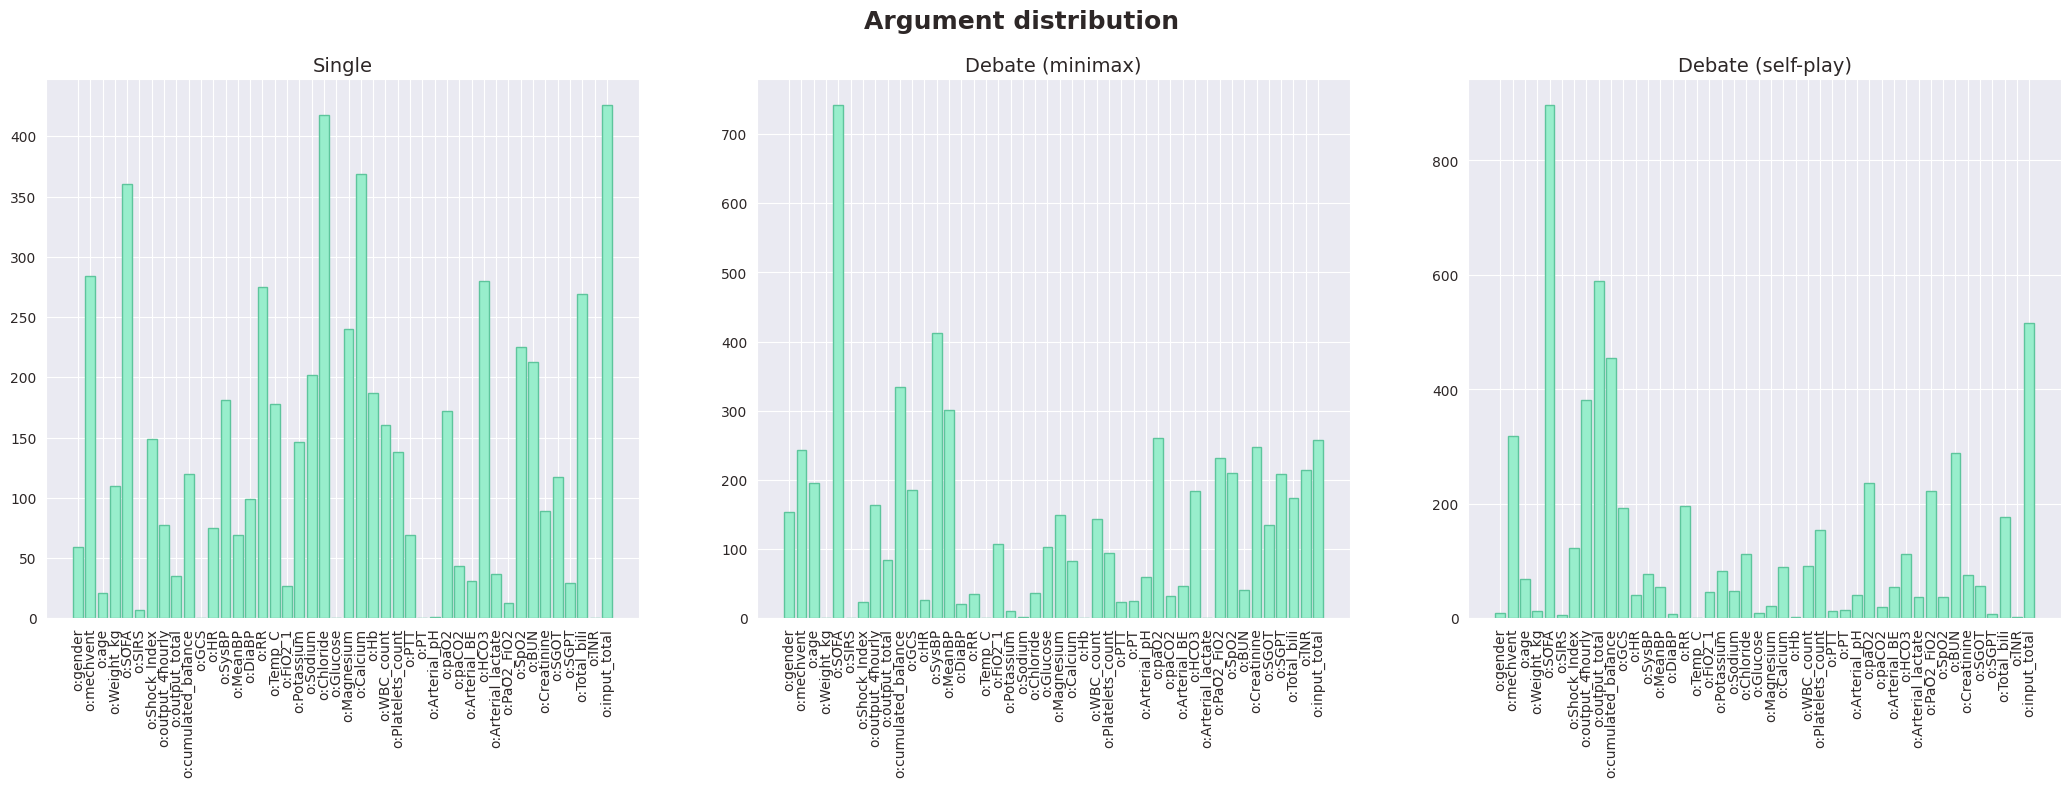

In [12]:
fig, (ax11, ax12, ax13) = plt.subplots(1, 3, figsize=(26, 7), gridspec_kw={"hspace": 0.9, "wspace": 0.2})
fig.suptitle("Argument distribution", weight="bold", fontsize=18, color="#2D2727")
plot_argument_distribution(env, model_argumentator_adaptive, episodes=1000, title="Single", axes=ax11)
plot_argument_distribution(env, model_debate_minimax, episodes=1000, title="Debate (minimax)", axes=ax12)
plot_argument_distribution(env, model_debate_selfplay, episodes=1000, title="Debate (self-play)", axes=ax13)

### Judge Reward Analysis

The following represents evaluation of environment reward obtained over the test set, for both argumentator and debate agents. A positive reward is issued whenever an agent convinces a judge of the true (preferred) action.

In [31]:
env = DummyVectorEnv([lambda: SepsisArgumentationEnv(dataloader=dataloader, judge=judge, action_dim=ACTION_DIM, state_dim=STATE_DIM, num_arguments=NUM_ARGUMENTS, eval=True)])
env.seed(SEED)
coll_argumentator = Collector(policy=model_argumentator_adaptive, env=env, buffer=ReplayBuffer(size=1e5))

env = DummyVectorEnv([lambda: SepsisArgumentationEnv(dataloader=dataloader, judge=judge, opponent=model_debate_minimax, action_dim=ACTION_DIM, state_dim=STATE_DIM, num_arguments=NUM_ARGUMENTS, eval=True)])
env.seed(SEED)
coll_debate = Collector(policy=model_debate_minimax, env=env, buffer=ReplayBuffer(size=1e5))

env = DummyVectorEnv([lambda: SepsisArgumentationEnv(dataloader=dataloader, judge=judge, opponent=model_debate_selfplay, action_dim=ACTION_DIM, state_dim=STATE_DIM, num_arguments=NUM_ARGUMENTS, eval=True)])
env.seed(SEED)
coll_debate_selfplay = Collector(policy=model_debate_selfplay, env=env, buffer=ReplayBuffer(size=1e5))

res_argumentator = coll_argumentator.collect(n_episode=1000)
res_debate = coll_debate.collect(n_episode=1000)
res_debate_selfplay = coll_debate.collect(n_episode=1000)

Additional evaluation that tests if isolated argumentation trained to propose L/2=3 evidence is more resilient to an adversarial confuser. This aims to address the reviewer's concerns regarding experimental setup pertaining to the isolated agent. 

In [29]:
# isolated
env = DummyVectorEnv([lambda: SepsisArgumentationEnv(dataloader=dataloader, judge=judge, action_dim=ACTION_DIM, state_dim=STATE_DIM, num_arguments=NUM_ARGUMENTS, eval=True)])
env.seed(SEED)
coll_argumentator_precommit = Collector(policy=model_argumentator_precommit, env=env, buffer=ReplayBuffer(size=1e5))
res_argumentator_precommit = coll_argumentator_precommit.collect(n_episode=1000)

# confuser vs. isolated
env = DummyVectorEnv([lambda: SepsisArgumentationEnv(dataloader=dataloader, judge=judge, opponent=model_confuser_argumentator_precommit, propose_evidence_upfront=True, action_dim=ACTION_DIM, state_dim=STATE_DIM, num_arguments=NUM_ARGUMENTS, eval=True)])
env.seed(SEED)
coll_argumentator_precommit = Collector(policy=model_argumentator_precommit, env=env, buffer=ReplayBuffer(size=1e5))
res_argumentator_precommit_confused = coll_argumentator_precommit.collect(n_episode=1000)

Additional results evaluating `maxmin` and `self-play` models trained with judge's evaluation difference used when defining utility function. This was done as part of the rebuttal procedure.

In [34]:
# debate maxmin
env = DummyVectorEnv([lambda: SepsisArgumentationEnv(dataloader=dataloader, judge=judge, opponent=model_debate_minimax_rewdiff, action_dim=ACTION_DIM, state_dim=STATE_DIM, num_arguments=NUM_ARGUMENTS, eval=True)])
env.seed(SEED)
coll_debate_minimax_rewdiff = Collector(policy=model_debate_minimax_rewdiff, env=env, buffer=ReplayBuffer(size=1e5))

# debate self-play
env = DummyVectorEnv([lambda: SepsisArgumentationEnv(dataloader=dataloader, judge=judge, opponent=model_debate_selfplay_rewdiff, action_dim=ACTION_DIM, state_dim=STATE_DIM, num_arguments=NUM_ARGUMENTS, eval=True)])
env.seed(SEED)
coll_debate_selfplay_rewdiff = Collector(policy=model_debate_selfplay_rewdiff, env=env, buffer=ReplayBuffer(size=1e5))

# debate vs. confuser (maxmin)
env = DummyVectorEnv([lambda: SepsisArgumentationEnv(dataloader=dataloader, judge=judge, opponent=model_confuser_debate_rewdiff, action_dim=ACTION_DIM, state_dim=STATE_DIM, num_arguments=NUM_ARGUMENTS, eval=True)])
env.seed(SEED)
coll_debate_minimax_rewdiff_confused = Collector(policy=model_debate_minimax_rewdiff, env=env, buffer=ReplayBuffer(size=1e5))

# debate vs. confuser (self-play)
env = DummyVectorEnv([lambda: SepsisArgumentationEnv(dataloader=dataloader, judge=judge, opponent=model_confuser_debate_selfplay_rewdiff, action_dim=ACTION_DIM, state_dim=STATE_DIM, num_arguments=NUM_ARGUMENTS, eval=True)])
env.seed(SEED)
coll_debate_selfplay_rewdiff_confused = Collector(policy=model_debate_selfplay_rewdiff, env=env, buffer=ReplayBuffer(size=1e5))

# collect results
res_debate_minimax_rewdiff = coll_debate_minimax_rewdiff.collect(n_episode=1000)
res_debate_selfplay_rewdiff = coll_debate_selfplay_rewdiff.collect(n_episode=1000)
res_debate_minimax_rewdiff_confused = coll_debate_minimax_rewdiff_confused.collect(n_episode=1000)
res_debate_selfplay_rewdiff_confused = coll_debate_selfplay_rewdiff_confused.collect(n_episode=1000)

Evaluating 4-arg agents.

In [20]:
env_4arg = DummyVectorEnv([lambda: SepsisArgumentationEnv(dataloader=dataloader, judge=judge_4arg, action_dim=ACTION_DIM, state_dim=STATE_DIM, num_arguments=4, eval=True)])
env_4arg.seed(SEED)
coll_argumentator_4arg = Collector(policy=model_argumentator_4arg, env=env_4arg, buffer=ReplayBuffer(size=1e5))

env_4arg = DummyVectorEnv([lambda: SepsisArgumentationEnv(dataloader=dataloader, judge=judge_4arg, opponent=model_debate_minimax_4arg, action_dim=ACTION_DIM, state_dim=STATE_DIM, num_arguments=4, eval=True)])
env_4arg.seed(SEED)
coll_debate_4arg = Collector(policy=model_debate_minimax_4arg, env=env_4arg, buffer=ReplayBuffer(size=1e5))

env_4arg = DummyVectorEnv([lambda: SepsisArgumentationEnv(dataloader=dataloader, judge=judge_4arg, opponent=model_debate_selfplay_4arg, action_dim=ACTION_DIM, state_dim=STATE_DIM, num_arguments=4, eval=True)])
env_4arg.seed(SEED)
coll_debate_selfplay_4arg = Collector(policy=model_debate_selfplay_4arg, env=env_4arg, buffer=ReplayBuffer(size=1e5))

res_argumentator_4arg = coll_argumentator_4arg.collect(n_episode=1000)
res_debate_4arg = coll_debate_4arg.collect(n_episode=1000)
res_debate_selfplay_4arg = coll_debate_4arg.collect(n_episode=1000)

### Confuser Evaluation

This section evaluates single and debate agents against fine-tuned confuser agents.

In [25]:
env = DummyVectorEnv([lambda: SepsisArgumentationEnv(dataloader=dataloader, judge=judge, opponent=model_confuser_argumentator_adaptive, action_dim=ACTION_DIM, state_dim=STATE_DIM, num_arguments=NUM_ARGUMENTS, eval=True)])
env.seed(SEED)
coll_argumentator = Collector(policy=model_argumentator_adaptive, env=env, buffer=ReplayBuffer(size=1e5))

env = DummyVectorEnv([lambda: SepsisArgumentationEnv(dataloader=dataloader, judge=judge, opponent=model_confuser_debate, action_dim=ACTION_DIM, state_dim=STATE_DIM, num_arguments=NUM_ARGUMENTS, eval=True)])
env.seed(SEED)
coll_debate = Collector(policy=model_debate_minimax, env=env, buffer=ReplayBuffer(size=1e5))

env = DummyVectorEnv([lambda: SepsisArgumentationEnv(dataloader=dataloader, judge=judge, opponent=model_confuser_debate_selfplay, action_dim=ACTION_DIM, state_dim=STATE_DIM, num_arguments=NUM_ARGUMENTS, eval=True)])
env.seed(SEED)
coll_debate_selfplay = Collector(policy=model_debate_selfplay, env=env, buffer=ReplayBuffer(size=1e5))

res_argumentator_confused = coll_argumentator.collect(n_episode=1000)
res_debate_confused = coll_debate.collect(n_episode=1000)
res_debate_selfplay_confused = coll_debate.collect(n_episode=1000)

Evaluating 4-arg agents.

In [52]:
env_4arg = DummyVectorEnv([lambda: SepsisArgumentationEnv(dataloader=dataloader, judge=judge_4arg, opponent=model_confuser_argumentator_4arg, action_dim=ACTION_DIM, state_dim=STATE_DIM, num_arguments=4, eval=True)])
env_4arg.seed(SEED)
coll_argumentator_4arg = Collector(policy=model_argumentator_4arg, env=env_4arg, buffer=ReplayBuffer(size=1e5))

env_4arg = DummyVectorEnv([lambda: SepsisArgumentationEnv(dataloader=dataloader, judge=judge_4arg, opponent=model_confuser_debate_4arg, action_dim=ACTION_DIM, state_dim=STATE_DIM, num_arguments=4, eval=True)])
env_4arg.seed(SEED)
coll_debate_4arg = Collector(policy=model_debate_minimax_4arg, env=env_4arg, buffer=ReplayBuffer(size=1e5))

env_4arg = DummyVectorEnv([lambda: SepsisArgumentationEnv(dataloader=dataloader, judge=judge_4arg, opponent=model_confuser_debate_selfplay_4arg, action_dim=ACTION_DIM, state_dim=STATE_DIM, num_arguments=4, eval=True)])
env_4arg.seed(SEED)
coll_debate_selfplay_4arg = Collector(policy=model_debate_selfplay_4arg, env=env_4arg, buffer=ReplayBuffer(size=1e5))

res_argumentator_confused_4arg = coll_argumentator_4arg.collect(n_episode=1000)
res_debate_confused_4arg = coll_debate_4arg.collect(n_episode=1000)
res_debate_selfplay_confused_4arg = coll_debate_4arg.collect(n_episode=1000)

In [ ]:
data = pd.DataFrame(itertools.chain(*[
    [{"model": "single (6 arg)", "kind": "without confuser", "num_arguments": 6, "rew": rew} for rew in res_argumentator["rews"]],
    [{"model": "single (6 arg)", "kind": "with confuser", "num_arguments": 6, "rew": rew} for rew in res_argumentator_confused["rews"]],
    [{"model": "debate (minimax, 6 arg)", "kind": "without confuser", "num_arguments": 6, "rew": rew} for rew in res_debate["rews"]],
    [{"model": "debate (minimax, 6 arg)", "kind": "with confuser", "num_arguments": 6,  "rew": rew} for rew in res_debate_confused["rews"]],
    [{"model": "debate (self-play, 6 arg)", "kind": "without confuser", "num_arguments": 6,  "rew": rew} for rew in res_debate_selfplay["rews"]],
    [{"model": "debate (self-play, 6 arg)", "kind": "with confuser", "num_arguments": 6,  "rew": rew} for rew in res_debate_selfplay_confused["rews"]],
    [{"model": "single (4 arg)", "kind": "without confuser", "num_arguments": 4, "rew": rew} for rew in res_argumentator_4arg["rews"]],
    [{"model": "single (4 arg)", "kind": "with confuser", "num_arguments": 4, "rew": rew} for rew in res_argumentator_confused_4arg["rews"]],
    [{"model": "debate (minimax, 4 arg)", "kind": "without confuser", "num_arguments": 4, "rew": rew} for rew in res_debate_4arg["rews"]],
    [{"model": "debate (minimax, 4 arg)", "kind": "with confuser", "num_arguments": 4,  "rew": rew} for rew in res_debate_confused_4arg["rews"]],
    [{"model": "debate (self-play, 4 arg)", "kind": "without confuser", "num_arguments": 4,  "rew": rew} for rew in res_debate_selfplay_4arg["rews"]],
    [{"model": "debate (self-play, 4 arg)", "kind": "with confuser", "num_arguments": 4,  "rew": rew} for rew in res_debate_selfplay_confused_4arg["rews"]],
    [{"model": "single (3 arg)", "kind": "without confuser", "num_arguments": 3, "rew": rew} for rew in res_argumentator_precommit["rews"]],
    [{"model": "single (3 arg)", "kind": "with confuser", "num_arguments": 3, "rew": rew} for rew in res_argumentator_precommit_confused["rews"]],
    [{"model": "debate (minimax, 6 arg, rewdiff)", "kind": "without confuser", "num_arguments": 6, "rew": rew} for rew in res_debate_minimax_rewdiff["rews"]],
    [{"model": "debate (minimax, 6 arg, rewdiff)", "kind": "with confuser", "num_arguments": 6, "rew": rew} for rew in res_debate_minimax_rewdiff_confused["rews"]],
    [{"model": "debate (self-play, 6 arg, rewdiff)", "kind": "without confuser", "num_arguments": 6, "rew": rew} for rew in res_debate_selfplay_rewdiff["rews"]],
    [{"model": "debate (self-play, 6 arg, rewdiff)", "kind": "with confuser", "num_arguments": 6, "rew": rew} for rew in res_debate_selfplay_rewdiff_confused["rews"]],
]))
data.to_csv(RESULTS_DIR / "argumentator_vs_confuser.csv", index=False)

## XAI Evaluation

This section runs the experiment comparing alingment capabilities of SHAP-based explanations.

In [ ]:
test_dict = torch.load("./assets/data/sepsis/test_dict.pt", map_location=DEVICE)
judge = torch.load(JUDGE_PATH, map_location=DEVICE).eval().to(DEVICE)
clinician = torch.load("./assets/models/clinician/clinician.pt", map_location=DEVICE)["model"].eval().to(DEVICE)
protagonist_l00_jstf  = [torch.load(f"./assets/models/protagonist/ddqn/justifiable/6/l00/protagonist-s{s}.pt", map_location=DEVICE)["model"].eval() for s in SEEDS]
protagonist_l25_jstf  = [torch.load(f"./assets/models/protagonist/ddqn/justifiable/6/l25/protagonist-s{s}.pt", map_location=device)["model"].eval() for s in SEEDS]
protagonist_l50_jstf  = [torch.load(f"./assets/models/protagonist/ddqn/justifiable/6/l50/protagonist-s{s}.pt", map_location=device)["model"].eval() for s in SEEDS]
protagonist_l75_jstf  = [torch.load(f"./assets/models/protagonist/ddqn/justifiable/6/l75/protagonist-s{s}.pt", map_location=device)["model"].eval() for s in SEEDS]
protagonist_l100_jstf = [torch.load(f"./assets/models/protagonist/ddqn/justifiable/6/l100/protagonist-s{s}.pt", map_location=device)["model"].eval() for s in SEEDS]

In [ ]:
dataset, dataloader, _ = get_judge_dataset(load_path=DATA_PREFERENCES_PATH, batch_size=1, data_dict=test_dict, device=DEVICE)

In [ ]:
def get_lime_predict_fn(policy: DQNPolicy):
    def _predict(data: np.ndarray):
        nonlocal policy
        if isinstance(policy, DQNPolicy):
            batch = Batch(obs=data, info={})
            logits = policy(batch).logits.detach().cpu()
            return F.softmax(logits, dim=-1).numpy()
    return _predict

In [ ]:
def get_shap_reward(state: torch.Tensor, action: torch.Tensor, shap_values: List[np.ndarray], action_alt: Optional[torch.Tensor] = None):
    shap_indices = torch.tensor(shap_values[action.item()])
    shap_indices = torch.topk(shap_indices, k=NUM_ARGUMENTS)[1].flatten()
    args_shap, args_mask_shap = torch.zeros_like(state), torch.zeros_like(state)
    args_shap[:, shap_indices], args_mask_shap[:, shap_indices] = state[:, shap_indices], 1
    rew_act = judge((args_shap, args_mask_shap, action))
    rew_alt = judge((args_shap, args_mask_shap, action_alt)) if action_alt is not None else None
    return rew_act, rew_alt if action_alt is not None else rew_act

In [ ]:
def get_lime_reward(state: torch.Tensor, action: torch.Tensor, explanation: lime.explanation.Explanation):
    indices = [ARGUMENTS.index(name) for name, _ in explanation.as_list(label=action.item())]
    args, args_mask = torch.zeros((1, len(ARGUMENTS))).to(state.device), torch.zeros((1, len(ARGUMENTS))).to(state.device)
    args[:, indices], args_mask[:, indices] = state[:, indices], 1
    return judge((args, args_mask, action))

In [ ]:
def xai_alignment(
    model: str,
    label: str,
    argumentator: Optional[MaskedPPO] = None,
    protagonist: Optional[DQNPolicy] = None,
    num_comparisons: int = 500,
    background_samples: int = 100,
    seed: str = None,
):
    items = []
    dataset, _, _ = get_judge_dataset(load_path=DATA_PREFERENCES_PATH, batch_size=1, data_dict=test_dict)
    dataset_background = dataset[:][0][torch.randint(0, len(dataset), (background_samples, ))].to(DEVICE)
    dataloader = DataLoader(Subset(dataset, torch.randint(0, len(dataset), (num_comparisons, ))), batch_size=1, num_workers=0)

    for s, a1, a2, pref in tqdm.tqdm(dataloader):
        s, a1, a2, pref = s.to(DEVICE), a1.to(DEVICE), a2.to(DEVICE), pref.to(DEVICE)

        # obtain the preferred action a_p and alternative action a_{1-p}
        a_t = a1 if pref.flatten()[0].item() == 1.0 else a2
        a_r = a1 if pref.flatten()[0].item() == 0.0 else a2

        # propose evidence by the argumentative method
        if model == "argumentator" and label == "single":
            rew_t = run_debate(s_t=s, a_p1=a_t, a_p2=None, judge=judge, argumentator=argumentator, num_arguments=NUM_ARGUMENTS, device=DEVICE)
            rew_r = run_debate(s_t=s, a_p1=a_r, a_p2=None, judge=judge, argumentator=argumentator, num_arguments=NUM_ARGUMENTS, device=DEVICE)
        elif model == "argumentator" and label in ["minimax", "self-play"]:
            rew_t, rew_r = run_debate(s_t=s, a_p1=a_t, a_p2=a_r, judge=judge, argumentator=argumentator, num_arguments=NUM_ARGUMENTS, device=DEVICE)
        elif model == "shap":
            shap_explainer = DeepExplainer(torch.nn.Sequential(protagonist.model.model, protagonist.model.Q), dataset_background)
            shap_values = shap_explainer.shap_values(s)
            rew_t, rew_r = get_shap_reward(state=s, action=a_t, shap_values=shap_values), get_shap_reward(state=s, action=a_r, shap_values=shap_values)
        elif model == "lime":
            explainer = lime.lime_tabular.LimeTabularExplainer(training_data=dataset_background.cpu().numpy(), mode="classification",
                                                               feature_names=ARGUMENTS, discretize_continuous=False, random_state=SEED)
            explanation = explainer.explain_instance(data_row=s.cpu().flatten().numpy(), predict_fn=get_lime_predict_fn(protagonist),
                                                     labels=[a_t.item(), a_r.item()], num_features=NUM_ARGUMENTS)
            rew_t, rew_r = get_lime_reward(state=s, action=a_t, explanation=explanation), get_lime_reward(state=s, action=a_r, explanation=explanation) 
        else:
            raise RuntimeError(f"Unknown model: {model}")

        # obtain the comparison
        items.append({"model": model, "label": label, "seed": seed, "won": (rew_t >= rew_r).int().item()})

    return items

Evaluating robustness of SHAP/LIME. This experiment was added after the submission deadline, and is therefore not included in the main paper.

In [ ]:
def xai_robustness(method: Literal["shap"], clinician: ClinicianPolicy, confuser: MaskedPPO, num_comparisons: int = 1000, num_arguments: int = 6, device: str = "cuda", seed: int = None):
    items = []
    dataset_background = torch.load(DATA_XAI_BACKGROUND_PATH, map_location=device)
    _, dataloader, _ = get_xai_debate_dataset(method=method, clinician=clinician.to(device), limit=num_comparisons, num_arguments=num_arguments // 2, 
                                                background_dataset_path=DATA_XAI_BACKGROUND_PATH,  preferences_path=DATA_PREFERENCES_PATH, batch_size=1, num_workers=0, device=device)

    # evaluation without confuser
    for s, a1, a2, pref, _ in tqdm.tqdm(dataloader, desc=f"Evaluating '{method}' without confuser"):
        s, a1, a2, pref = s.to(device), a1.to(device), a2.to(device), pref.to(device)

        a_t = a1 if pref.flatten()[0].item() == 1.0 else a2
        a_r = a1 if pref.flatten()[0].item() == 0.0 else a2

        shap_explainer = DeepExplainer(clinician.to(device).model, dataset_background)
        shap_values = shap_explainer.shap_values(s)
        rew_t, rew_r = get_shap_reward(state=s, action=a_t, action_alt=a_r, shap_values=shap_values)

        items.append({"method": method, "label": "without confuser", "num_arguments": num_arguments, "rew": (rew_t >= rew_r).cpu().int().item()})

    # evaluation with confuser
    env = lambda: SepsisArgumentationEnv(dataloader=dataloader, judge=judge.to(DEVICE), inverse_reward=True, xai=True, start_player=1, device=device, num_arguments=num_arguments, action_dim=ACTION_DIM, state_dim=STATE_DIM, eval=True)
    env = DummyVectorEnv([env])
    env.seed(seed)
    
    collector = Collector(policy=confuser.to(device), env=env, buffer=ReplayBuffer(size=1e5))
    result = collector.collect(n_episode=1000)
    items += [{"method": method, "label": "with confuser", "num_arguments": num_arguments, "rew": 1 - rew} for rew in result["rews"]]

    return items

In [ ]:
data = pd.DataFrame(
    xai_robustness(method="shap", clinician=clinician, confuser=model_confuser_shap, num_comparisons=1000, num_arguments=NUM_ARGUMENTS, device=DEVICE, seed=SEED) +
    xai_robustness(method="lime", clinician=clinician, confuser=model_confuser_lime, num_comparisons=1000, num_arguments=NUM_ARGUMENTS, device=DEVICE, seed=SEED))
data.to_csv(RESULTS_DIR / "xai_robustness.csv", index=False)

Evaluating alignment of SHAP/LIME.

In [ ]:
data = pd.DataFrame(
    xai_alignment(model="argumentator", label="single", argumentator=model_argumentator_adaptive, protagonist=None, num_comparisons=1000) +
    xai_alignment(model="argumentator", label="minimax", argumentator=model_debate_minimax, protagonist=None, num_comparisons=1000) +
    xai_alignment(model="argumentator", label="self-play", argumentator=model_debate_selfplay, protagonist=None, num_comparisons=1000) +
    list(itertools.chain(*[xai_alignment(model="shap", label="λ=0.0", argumentator=None, protagonist=protagonist_l00_jstf[i], seed=seed, num_comparisons=200, background_samples=100) for i, seed in enumerate(SEEDS)])) +
    list(itertools.chain(*[xai_alignment(model="shap", label="λ=0.25", argumentator=None, protagonist=protagonist_l25_jstf[i], seed=seed, num_comparisons=200, background_samples=100) for i, seed in enumerate(SEEDS)])) +
    list(itertools.chain(*[xai_alignment(model="shap", label="λ=0.50", argumentator=None, protagonist=protagonist_l50_jstf[i], seed=seed, num_comparisons=200, background_samples=100) for i, seed in enumerate(SEEDS)])) +
    list(itertools.chain(*[xai_alignment(model="shap", label="λ=0.75", argumentator=None, protagonist=protagonist_l75_jstf[i], seed=seed, num_comparisons=200, background_samples=100) for i, seed in enumerate(SEEDS)])) +
    list(itertools.chain(*[xai_alignment(model="shap", label="λ=1.0", argumentator=None, protagonist=protagonist_l100_jstf[i], seed=seed, num_comparisons=200, background_samples=100) for i, seed in enumerate(SEEDS)])) +
    list(itertools.chain(*[xai_alignment(model="lime", label="λ=0.0", argumentator=None, protagonist=protagonist_l00_jstf[i], seed=seed, num_comparisons=200, background_samples=100) for i, seed in enumerate(SEEDS)])) +
    list(itertools.chain(*[xai_alignment(model="lime", label="λ=0.25", argumentator=None, protagonist=protagonist_l25_jstf[i], seed=seed, num_comparisons=200, background_samples=100) for i, seed in enumerate(SEEDS)])) +
    list(itertools.chain(*[xai_alignment(model="lime", label="λ=0.50", argumentator=None, protagonist=protagonist_l50_jstf[i], seed=seed, num_comparisons=200, background_samples=100) for i, seed in enumerate(SEEDS)])) +
    list(itertools.chain(*[xai_alignment(model="lime", label="λ=0.75", argumentator=None, protagonist=protagonist_l75_jstf[i], seed=seed, num_comparisons=200, background_samples=100) for i, seed in enumerate(SEEDS)])) +
    list(itertools.chain(*[xai_alignment(model="lime", label="λ=1.0", argumentator=None, protagonist=protagonist_l100_jstf[i], seed=seed, num_comparisons=200, background_samples=100) for i, seed in enumerate(SEEDS)])))
data.to_csv(RESULTS_DIR / "xai_alignment.csv", index=False)